In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Load data and prepare GDP matching using fuzzy matching
from difflib import get_close_matches
import re

cost_columns = ["total_cost_0","total_cost_2020","total_cost_2050","total_cost_future_2030","total_cost_future_2040","total_cost_future_2050"]
df = pd.read_csv('output_scenario.csv')

# Load GDP data
gdp_df = pd.read_csv('gdp.csv')

# Extract 2020 GDP per capita data
gdp_2020 = gdp_df[['Country Name', '2020']].copy()
gdp_2020.columns = ['Country', 'GDP_per_capita_2020']
gdp_2020['GDP_per_capita_2020'] = pd.to_numeric(gdp_2020['GDP_per_capita_2020'], errors='coerce')

# Clean country names function
def clean_country_name(name):
    if pd.isna(name):
        return ""
    # Remove extra spaces and convert to lowercase
    name = str(name).strip().lower()
    # Remove common prefixes/suffixes
    name = re.sub(r'\b(republic of|kingdom of|state of|federation of)\b', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Function to fuzzy match country names
def fuzzy_match_country(country, gdp_countries, threshold=0.6):
    if pd.isna(country):
        return None
    
    # Handle multiple countries (separated by semicolon)
    if ';' in str(country):
        countries = [c.strip() for c in str(country).split(';')]
        country = countries[0]  # Use first country
    
    # Clean the country name
    clean_country = clean_country_name(country)
    if not clean_country:
        return None
    
    # Clean GDP country names for matching
    clean_gdp_countries = [clean_country_name(c) for c in gdp_countries]
    clean_to_original = dict(zip(clean_gdp_countries, gdp_countries))
    
    # Try exact match first
    if clean_country in clean_gdp_countries:
        return clean_to_original[clean_country]
    
    # Use fuzzy matching
    matches = get_close_matches(clean_country, clean_gdp_countries, n=1, cutoff=threshold)
    if matches:
        return clean_to_original[matches[0]]
    
    # Try partial matching for common cases
    for clean_gdp, orig_gdp in clean_to_original.items():
        if clean_country in clean_gdp or clean_gdp in clean_country:
            return orig_gdp
    
    return None

# Match countries using fuzzy matching
gdp_countries = list(gdp_2020['Country'].dropna())
df['GDP_Country'] = df['Country'].apply(lambda x: fuzzy_match_country(x, gdp_countries))

# Merge GDP data
df = df.merge(gdp_2020[['Country', 'GDP_per_capita_2020']], 
              left_on='GDP_Country', right_on='Country', 
              how='left', suffixes=('', '_gdp'))

# Calculate per capita costs (cost per person)
df[cost_columns] = df[cost_columns].div(df['pop'], axis=0)

# Calculate EIBC (cost/GDP) - for all five scenarios
df['EIBC_0'] = df['total_cost_0'] / df['GDP_per_capita_2020']
df['EIBC_2020'] = df['total_cost_2020'] / df['GDP_per_capita_2020']
df['EIBC_2050'] = df['total_cost_2050'] / df['GDP_per_capita_2020']
df['EIBC_future_2030'] = df['total_cost_future_2030'] / df['GDP_per_capita_2020']
df['EIBC_future_2040'] = df['total_cost_future_2040'] / df['GDP_per_capita_2020']
df['EIBC_future_2050'] = df['total_cost_future_2050'] / df['GDP_per_capita_2020']

print(f"Successfully matched GDP data for {df['GDP_per_capita_2020'].notna().sum()} out of {len(df)} countries")
print(f"Countries with missing GDP data: {df[df['GDP_per_capita_2020'].isna()]['Country'].unique()}")
df

Successfully matched GDP data for 1870 out of 1899 countries
Countries with missing GDP data: ['Saint Helena' 'Wallis and Futuna' 'Mayotte' 'East Timor' 'Venezuela'
 'Eritrea' 'Guadeloupe' 'British Virgin Islands' 'North Korea'
 'Saint Pierre and Miquelon' 'Jersey']


,lat,lon,total_cost_0,total_cost_2020,total_cost_2050,total_cost_future_2030,total_cost_future_2040,total_cost_future_2050,pop,Country,GDP_Country,Country_gdp,GDP_per_capita_2020,EIBC_0,EIBC_2020,EIBC_2050,EIBC_future_2030,EIBC_future_2040,EIBC_future_2050
0,-55.246549,-68.960532,1665.000064,1665.304525,1665.144343,1664.612715,1663.428458,1662.068419,129.0,Chile,Chile,Chile,13114.815470,0.126956,0.126979,0.126967,0.126926,0.126836,0.126732
1,-55.084701,-67.644515,275.832018,275.832018,275.832018,274.067581,273.458458,272.754733,1682.0,Chile,Chile,Chile,13114.815470,0.021032,0.021032,0.021032,0.020898,0.020851,0.020797
2,-54.798325,-64.315773,728.541074,1022.070525,1023.086040,1017.868910,1014.622610,1010.626129,240.0,Argentina,Argentina,Argentina,8535.599380,0.085353,0.119742,0.119861,0.119250,0.118870,0.118401
3,-54.054777,-68.677673,3.649083,3.649083,3.649084,3.649084,3.649084,3.647722,167448.0,Argentina; Chile,Argentina,Argentina,8535.599380,0.000428,0.000428,0.000428,0.000428,0.000428,0.000427
4,-53.964415,-70.595284,900.350219,900.350219,900.350219,888.693458,886.269026,883.706765,129.0,Chile,Chile,Chile,13114.815470,0.068651,0.068651,0.068651,0.067763,0.067578,0.067382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,64.990673,-18.594070,3.264480,3.419742,3.251823,3.242209,3.232377,3.219090,328476.0,Iceland,Iceland,Iceland,59023.566350,0.000055,0.000058,0.000055,0.000055,0.000055,0.000055
1895,65.026437,24.757215,883.415465,883.415465,883.112832,876.741645,874.433254,872.206741,929.0,Finland,Finland,Finland,48828.684690,0.018092,0.018092,0.018086,0.017955,0.017908,0.017863
1896,65.077007,35.699304,1902.934726,1902.936474,1788.678763,1783.068664,1779.741629,1775.727762,189.0,Russia,Tunisia,Tunisia,3548.653637,0.536241,0.536242,0.504044,0.502463,0.501526,0.500395
1897,65.548737,-37.140346,1618.843554,2736.328038,2643.213527,2639.662953,2635.626372,2631.072350,176.0,Greenland,Greenland,Greenland,54693.076680,0.029599,0.050031,0.048328,0.048263,0.048189,0.048106


正在读取EIBC数据...
读取到 58 个IPCC区域
正在将岛屿映射到IPCC区域...

各区域岛屿数量：
region_acronym
SEA    702
EAS    172
NEU    162
MED    115
SAS     88
EPO     88
SPO     85
CAR     65
ENA     43
WAF     32
NAU     30
NAO     26
SWS     26
NWN     25
WNA     18
Name: count, dtype: int64

至少有10个岛屿的区域：['SEA', 'EAS', 'NEU', 'MED', 'SAS', 'EPO', 'SPO', 'CAR', 'ENA', 'WAF', 'NAU', 'NAO', 'SWS', 'NWN', 'WNA', 'NPO', 'ARP', 'SCA', 'SSA', 'GIC', 'BOB', 'NZ', 'RFE']
有效岛屿数量：1778

多scenario数据形状: (23, 5)
Scenario含义:
  1. EIBC_0: Ideal
  2. EIBC_2020: Baseline
  3. EIBC_2050: Climate Stress
  4. EIBC_future_2030: TP2030
  5. EIBC_future_2040: TP2040
  6. EIBC_future_2050: TP2050


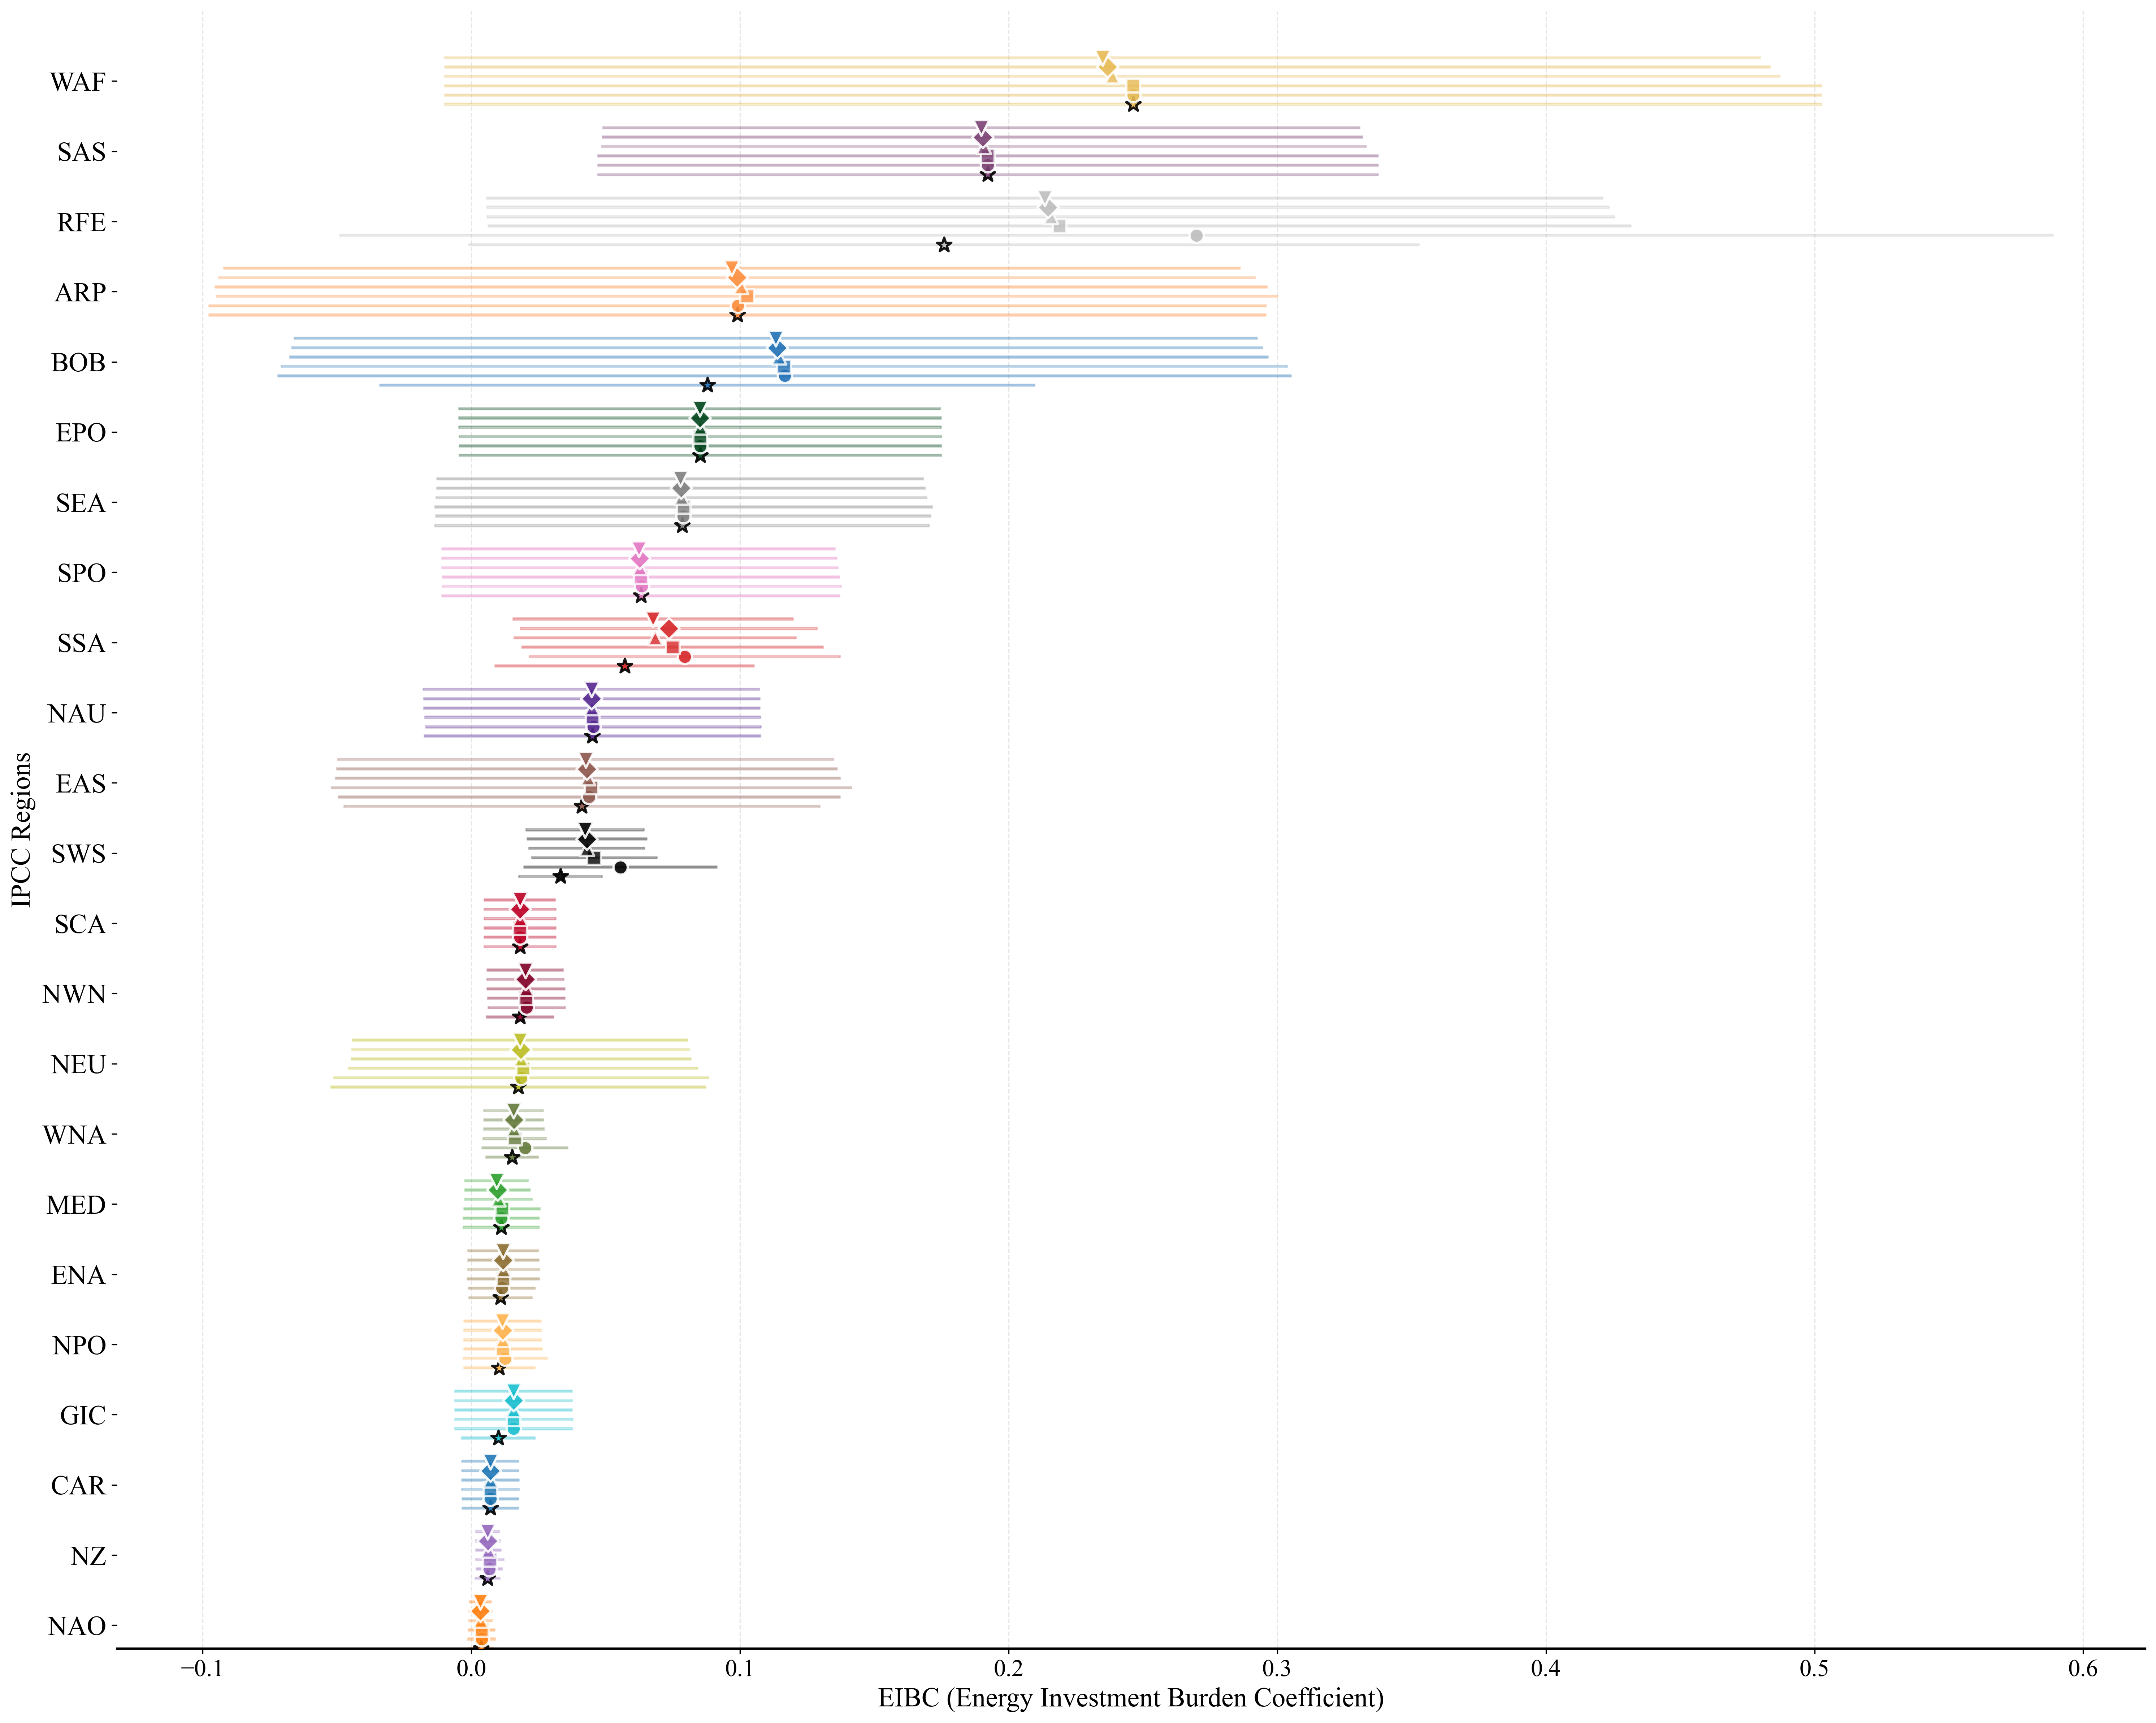

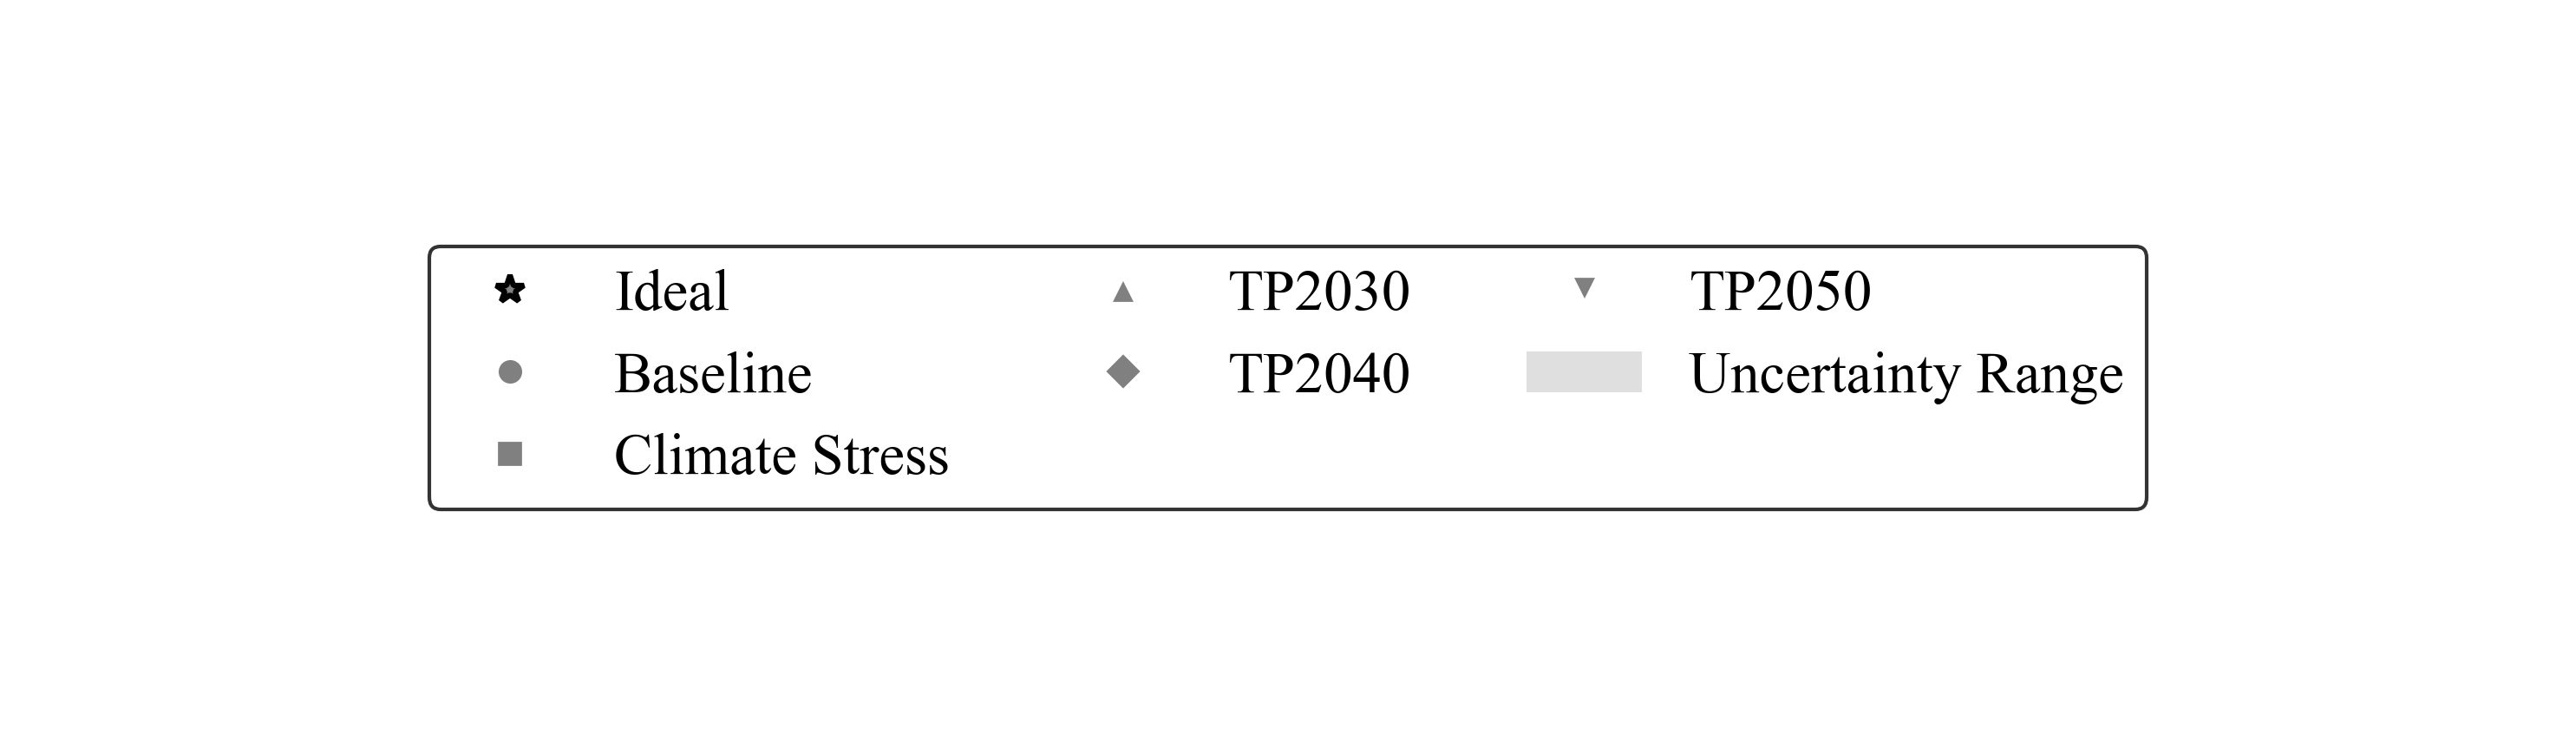

In [35]:
plt.rcParams['font.family'] = 'Times New Roman'

# 1. 读取岛屿数据和处理过的EIBC数据
print("正在读取EIBC数据...")
# df already contains our EIBC data from previous cell

# 2. 读取IPCC区域数据
import geopandas as gpd
from shapely.geometry import Point
from collections import defaultdict

ipcc_regions = gpd.read_file('../visualization/IPCC-WGI-reference-regions-v4.geojson')
print(f"读取到 {len(ipcc_regions)} 个IPCC区域")

# 3. 将岛屿坐标映射到IPCC区域
def map_islands_to_ipcc_regions(islands_df, ipcc_regions):
    """将岛屿坐标映射到IPCC区域"""
    island_region_mapping = []
    
    for idx, island in islands_df.iterrows():
        lat, lon = island['lat'], island['lon']
        point = Point(lon, lat)  # 注意经纬度的顺序
        
        # 查找包含该点的IPCC区域
        region_found = False
        for _, region in ipcc_regions.iterrows():
            if region.geometry.contains(point):
                island_region_mapping.append({
                    'lat': lat,
                    'lon': lon,
                    'region_name': region['Name'],
                    'region_acronym': region['Acronym'],
                    'continent': region['Continent']
                })
                region_found = True
                break
        
        if not region_found:
            island_region_mapping.append({
                'lat': lat,
                'lon': lon,
                'region_name': 'Unknown',
                'region_acronym': 'UNK',
                'continent': 'Unknown'
            })
    
    return pd.DataFrame(island_region_mapping)

print("正在将岛屿映射到IPCC区域...")
# 只选择有EIBC数据的岛屿
df_with_eibc = df.dropna(subset=['EIBC_0', 'EIBC_2020', 'EIBC_2050', 'EIBC_future_2030', 'EIBC_future_2040', 'EIBC_future_2050'])
island_region_map = map_islands_to_ipcc_regions(df_with_eibc, ipcc_regions)

# 4. 将区域信息合并回原数据
df_with_regions = df_with_eibc.reset_index(drop=True)
island_region_map = island_region_map.reset_index(drop=True)
df_with_regions = pd.concat([df_with_regions, island_region_map[['region_acronym']]], axis=1)

# 5. 计算每个区域的岛屿数量并筛选至少有10个岛屿的区域
region_counts = df_with_regions['region_acronym'].value_counts()
print("\n各区域岛屿数量：")
print(region_counts.head(15))

valid_regions = region_counts[region_counts >= 10].index.tolist()
print(f"\n至少有10个岛屿的区域：{valid_regions}")

# 过滤数据只保留有效区域的岛屿
df_valid = df_with_regions[df_with_regions['region_acronym'].isin(valid_regions)].copy()
print(f"有效岛屿数量：{len(df_valid)}")

# 6. 重新定义scenario的含义和排序
# 修正后的scenario理解：
# EIBC_2020: 2020年灾害场景 + 2020年成本场景
# EIBC_2050: 2050年灾害场景 + 2020年成本场景  
# EIBC_future_2030: 2050年灾害场景 + 2030年成本场景
# EIBC_future_2040: 2050年灾害场景 + 2040年成本场景
# EIBC_future_2050: 2050年灾害场景 + 2050年成本场景

# 按逻辑顺序排列：先2020基准，然后2050灾害的不同成本场景
scenario_columns = ['EIBC_0', 'EIBC_2020', 'EIBC_2050', 'EIBC_future_2030', 'EIBC_future_2040', 'EIBC_future_2050']
scenario_labels = ['Ideal', 'Baseline', 'Climate Stress', 'TP2030', 'TP2040', 'TP2050']
scenario_short_labels = ['Ideal', 'Baseline', 'Climate Stress', 'TP2030', 'TP2040', 'TP2050']

multi_scenario_data = []

for region in valid_regions:
    region_data = df_valid[df_valid['region_acronym'] == region]
    
    if len(region_data) > 0:
        scenario_means = []
        scenario_stds = []
        
        for col in scenario_columns:
            mean_val = region_data[col].mean()
            std_val = region_data[col].std()
            scenario_means.append(mean_val if not pd.isna(mean_val) else 0)
            scenario_stds.append(std_val if not pd.isna(std_val) else 0)
        
        multi_scenario_data.append({
            'region': region,
            'scenario_means': scenario_means,
            'scenario_stds': scenario_stds,
            'island_count': region_counts[region]
        })

# 转换为DataFrame并按2020年的值排序
df_multi = pd.DataFrame(multi_scenario_data)
df_multi['sort_key'] = [data[0] for data in df_multi['scenario_means']]  # 按2020年值排序
df_multi = df_multi.sort_values('sort_key', ascending=True).reset_index(drop=True)

print(f"\n多scenario数据形状: {df_multi.shape}")
print("Scenario含义:")
for i, (col, label) in enumerate(zip(scenario_columns, scenario_labels)):
    print(f"  {i+1}. {col}: {label}")

# 7. Nature期刊风格颜色
custom_colors = {
    'CAR': '#1f77b4',  # 蓝色
    'NAO': '#ff7f0e',  # 橙色
    'MED': '#2ca02c',  # 绿色
    'SSA': '#d62728',  # 红色
    'NZ':  '#9467bd',  # 紫色
    'EAS': '#8c564b',  # 棕色
    'SPO': '#e377c2',  # 粉色
    'SEA': '#7f7f7f',  # 灰色
    'NEU': '#bcbd22',  # 橄榄绿
    'GIC': '#17becf',  # 青色
    'AUS': '#393b79',  # 深蓝
    'WNA': '#637939',  # 橄榄
    'ENA': '#8c6d31',  # 土黄
    'CAS': '#843c39',  # 深红
    'SAS': '#7b4173',  # 深紫
    'WAS': '#5254a3',  # 靛蓝
    'WSA': '#6b6ecf',  # 浅蓝紫
    'NSA': '#9c9ede',  # 浅紫
    'SAF': '#cedb9c',  # 浅绿
    'WAF': '#e7ba52',  # 金黄
    'EAF': '#c7c7c7',  # 浅灰
    'CAF': '#de9ed6',  # 浅粉
    'MDG': '#31a354',  # 深绿
    'TIB': '#756bb1',  # 中紫
    'ESB': '#636363',  # 中灰
    'WSB': '#969696',  # 浅灰2
    'RFE': '#bdbdbd',  # 更浅灰
    'RAR': '#d9d9d9',  # 极浅灰
    'EEU': '#fd8d3c',  # 橙红
    'CEU': '#fdae6b',  # 浅橙
    'WCE': '#fdd0a2',  # 极浅橙
    'ECE': '#c6dbef',  # 极浅蓝
    'MES': '#9ecae1',  # 浅蓝
    'MEN': '#6baed6',  # 中蓝
    'ARO': '#4292c6',  # 深蓝2
    'BOB': '#2171b5',  # 更深蓝
    'ARS': '#08519c',  # 极深蓝
    'SCS': '#08306b',  # 最深蓝
    'IOD': '#74c476',  # 中绿
    'WIO': '#41ab5d',  # 深绿2
    'EIO': '#238b45',  # 更深绿
    'SIO': '#006d2c',  # 极深绿
    'EPO': '#00441b',  # 最深绿
    'NPO': '#feb24c',  # 中橙
    'ARP': '#fd8d3c',  # 深橙
    'SAH': '#f03b20',  # 橙红2
    'SCA': '#bd0026',  # 深红2
    'NWN': '#800026',  # 极深红
    'NAU': '#54278f',  # 深紫2
    'UNK': '#252525'   # 未知区域用黑色
}

# 调整scenario的视觉元素，基准场景不再特别突出
scenario_markers = ['*','o', 's', '^', 'D', 'v']  # 圆形, 方形, 上三角, 菱形, 下三角
scenario_alphas = [0.9, 0.9, 0.8, 0.8, 0.9, 0.9]  # 统一透明度，不再特别突出基准
scenario_sizes = [100, 90, 80, 90, 100, 110]  # 基准场景大小适中，不再最大

# 8. 绘制修改后的六scenario图（基准场景只有黑色边线区别）
fig, ax = plt.subplots(figsize=(20, 16), dpi=300)

# 调整区域间距和scenario点间距
y_spacing = 3  # 增加区域间距，从1.8增加到2.5
scenario_offsets = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0] # 6个scenario的偏移量，间距更合理

# 为每个区域创建多点哑铃图
for i, row in df_multi.iterrows():
    region = row['region']
    means = row['scenario_means']
    stds = row['scenario_stds']
    base_color = custom_colors.get(region, '#000000')
    
    # ==================== 主要修改点 ====================
    # 所有场景都使用该区域的基色，不再使用渐变
    scenario_colors = [base_color] * 6
    # ===================================================
    
    # 绘制不确定性区域（为所有6个scenario）
    for j, (mean_val, std_val) in enumerate(zip(means, stds)):
        if std_val > 0:
            y_offset = scenario_offsets[j]  # 使用新的偏移量
            ax.fill_betweenx([i * y_spacing + y_offset - 0.04, i * y_spacing + y_offset + 0.04], 
                             [mean_val - std_val, mean_val - std_val],
                             [mean_val + std_val, mean_val + std_val],
                             color=scenario_colors[j], alpha=0.25, zorder=1)
    
    # 绘制所有6个scenario的点
    for j, (mean_val, marker, alpha, size) in enumerate(zip(means, scenario_markers, scenario_alphas, scenario_sizes)):
        y_offset = scenario_offsets[j]  # 使用新的偏移量
        
        # 只有Ideal场景(j=0)用黑色边框，其他保持白色边框
        edge_width = 1.5
        edge_color = 'black' if j == 0 else 'white'
        
        ax.scatter(mean_val, i * y_spacing + y_offset, color=scenario_colors[j], s=size, alpha=alpha, 
                   zorder=4, edgecolors=edge_color, linewidths=edge_width, marker=marker,
                   label=f'{scenario_short_labels[j]}' if i == 0 else "")

# 设置y轴标签为区域名称，确保与区域中心对齐
region_labels = [f"{row['region']}" for _, row in df_multi.iterrows()]
y_ticks = [i * y_spacing for i in range(len(df_multi))]  # 确保标签对齐区域中心
ax.set_yticks(y_ticks)
ax.set_yticklabels(region_labels, fontsize=18)

# 美化图表
ax.set_xlabel('EIBC (Energy Investment Burden Coefficient)', fontsize=18)
ax.set_ylabel('IPCC Regions', fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=16)

# 添加网格线
ax.grid(True, axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 设置坐标轴样式
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)

# 调整y轴范围以适应新的间距
ax.set_ylim(-1, len(df_multi) * y_spacing)

# 统一图例中的点大小
legend_elements = []
legend_marker_size = 8

# 添加scenario说明
for j, (short_label, marker) in enumerate(zip(scenario_short_labels, scenario_markers)):
    edge_color = 'black' if j == 0 else 'white'
    edge_width = 1.5
    legend_elements.append(
        plt.Line2D([0], [0], marker=marker, color='gray', linestyle='None', 
                   markersize=legend_marker_size, markerfacecolor='gray', 
                   markeredgecolor=edge_color, markeredgewidth=edge_width, label=short_label)
    )

# 只保留不确定性区域说明
legend_elements.append(
    plt.Rectangle((0, 0), 1, 1, facecolor='gray', alpha=0.25, label='Uncertainty Range')
)

# 不在主图中显示图例
# ax.legend(handles=legend_elements, loc='lower right', fontsize=16, ncol=2)

plt.tight_layout()
plt.show()

# 单独绘制图例
fig_legend, ax_legend = plt.subplots(figsize=(10, 3), dpi=300)
ax_legend.axis('off')

# 创建图例
legend = ax_legend.legend(handles=legend_elements, loc='center', fontsize=16, ncol=3, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

plt.tight_layout()
plt.show()

C:\Users\18130\AppData\Local\Temp\ipykernel_15548\2734196107.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


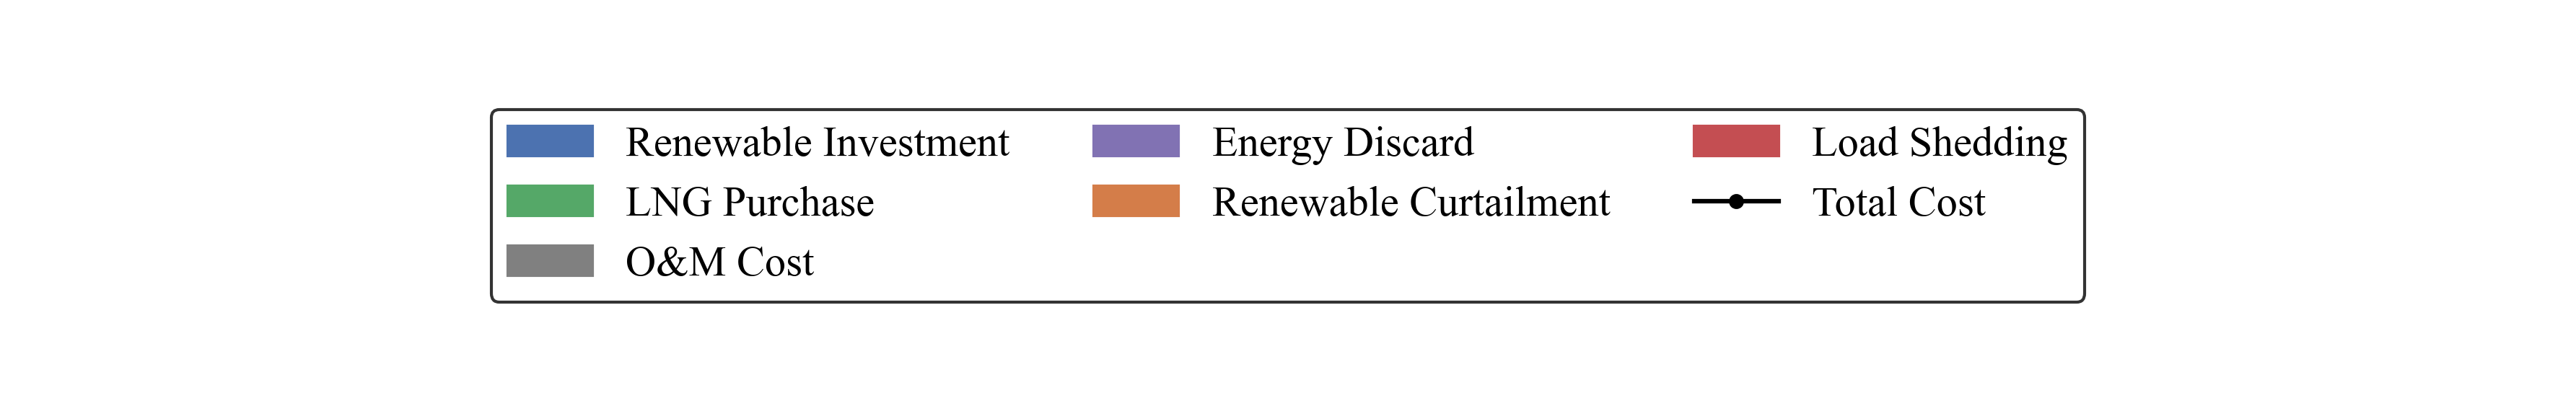

In [31]:
plt.rcParams['font.family'] = 'Times New Roman'

# 使用第三个cell中已经处理过的区域数据，确保完全对应

# 1. 读取不同scenario的cost数据，但只针对df_valid中的岛屿
import os
import glob
from collections import defaultdict


# 修正scenario目录定义
scenario_dirs = {
    'Ideal': '../result/output_0', 
    'Baseline': '../result/output_2020', 
    'Climate Stress': '../result/output_2050', 
    'TP2030': '../result/output_future_2030', 
    'TP2040': '../result/output_future_2040',
    'TP2050': '../result/output_future_2050'
}

# 函数：从文件名提取经纬度
def extract_lat_lon(filename):
    """从文件名中提取经纬度"""
    basename = os.path.basename(filename)
    parts = basename.replace('_best_cost.csv', '').split('_')
    if len(parts) >= 2:
        try:
            lat = float(parts[0])
            lon = float(parts[1])
            return lat, lon
        except ValueError:
            return None, None
    return None, None

# 函数：读取cost文件
def read_cost_file(filepath):
    """读取单个cost文件并返回cost数据字典"""
    costs = {}
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if ',' in line and not line.startswith('---'):
                    parts = line.split(',')
                    if len(parts) == 2:
                        cost_item = parts[0].strip()
                        try:
                            cost_value = float(parts[1].strip())
                            costs[cost_item] = cost_value
                        except ValueError:
                            continue
    except Exception as e:
        print(f"读取文件错误 {filepath}: {e}")
    return costs

# 创建df_valid中岛屿的坐标集合，用于快速查找
valid_coordinates = set()
for _, row in df_valid.iterrows():
    valid_coordinates.add((row['lat'], row['lon']))

# 存储所有scenario的数据，只包含df_valid中的岛屿
all_scenario_data = {}

# 读取每个scenario的数据
for scenario, dir_path in scenario_dirs.items():
    scenario_data = []
    
    if os.path.exists(dir_path):
        # 获取所有best_cost.csv文件
        cost_files = glob.glob(os.path.join(dir_path, '*_best_cost.csv'))
        
        matched_files = 0
        for cost_file in cost_files:
            lat, lon = extract_lat_lon(cost_file)
            if lat is not None and lon is not None:
                # 只处理df_valid中包含的坐标
                if (lat, lon) in valid_coordinates:
                    costs = read_cost_file(cost_file)
                    if costs:
                        # 提取主要cost类别
                        row_data = {
                            'lat': lat,
                            'lon': lon,
                            'scenario': scenario,
                            'renewable_cost': costs.get('Annualized Investment Cost', 0),
                            'lng_cost': costs.get('LNG Purchase Cost', 0),
                            'maintenance_cost': costs.get('Fixed Operation & Maintenance Cost', 0),
                            'discard_cost': costs.get('Energy Discard Cost (Heat/Cold)', 0),
                            'curtailment_cost': costs.get('Renewable Curtailment Cost', 0),
                            'load_shedding_cost': costs.get('Load Shedding Cost', 0),
                            'total_cost': costs.get('--- TOTAL ANNUAL COST ---', 0)
                        }
                        scenario_data.append(row_data)
                        matched_files += 1
        
    
    all_scenario_data[scenario] = pd.DataFrame(scenario_data)

# 2. 为cost数据添加区域信息（使用df_valid中的mapping）

# 创建坐标到区域的映射字典
coord_to_region = {}
for _, row in df_valid.iterrows():
    coord_to_region[(row['lat'], row['lon'])] = row['region_acronym']

# 为每个scenario的数据添加区域信息
for scenario in all_scenario_data:
    if len(all_scenario_data[scenario]) > 0:
        all_scenario_data[scenario]['region'] = all_scenario_data[scenario].apply(
            lambda row: coord_to_region.get((row['lat'], row['lon']), 'Unknown'), axis=1
        )

# 3. 使用第三个cell中df_multi的区域顺序（按2020年EIBC值从小到大排序）
region_order = [row['region'] for _, row in df_multi.iterrows()]  # df_multi来自第三个cell

# 4. 计算各区域的成本类别数据
cost_categories = ['renewable_cost', 'lng_cost', 'maintenance_cost', 
                   'discard_cost', 'curtailment_cost', 'load_shedding_cost']

# 为每个区域和scenario计算平均成本
region_scenario_costs = defaultdict(lambda: defaultdict(dict))

for scenario in ['Ideal', 'Baseline', 'Climate Stress', 'TP2030', 'TP2040', 'TP2050']:
    if scenario in all_scenario_data and len(all_scenario_data[scenario]) > 0:
        scenario_df = all_scenario_data[scenario]
        
        for region in region_order:  # 使用第三个cell的顺序
            region_data = scenario_df[scenario_df['region'] == region]
            
            if len(region_data) > 0:
                for cost_cat in cost_categories:
                    mean_cost = region_data[cost_cat].mean()
                    region_scenario_costs[region][scenario][cost_cat] = mean_cost if not pd.isna(mean_cost) else 0


# 5. 使用与第三个cell完全相同的样式设置
custom_labels = [
    "Renewable Investment", "LNG Purchase", "O&M Cost", 
    "Energy Discard", "Renewable Curtailment", "Load Shedding"
]

# 计算布局 - 与第三个cell保持一致
num_plots = len(region_order)
cols = 4  # 每行显示n个图
rows = (num_plots + cols - 1) // cols  # 计算需要几行

# 创建一个包含所有子图的图表
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), dpi=500, 
                        gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

# 将 axes 展平，方便按索引操作
if rows == 1 and cols == 1:
    axes = np.array([axes])
elif rows == 1:
    axes = np.array(axes).flatten()
else:
    axes = axes.flatten()

# 创建场景标签
scenario_labels = ['Ideal', 'Baseline', 'Climate Stress', 'TP2030', 'TP2040', 'TP2050']

# 绘制每个区域的图表，按照第三个cell的顺序
for i, region in enumerate(region_order):
    ax = axes[i]
    
    # 准备该区域的数据矩阵
    data = []
    for scenario in scenario_labels:
        if scenario in region_scenario_costs[region]:
            scenario_costs = []
            for cost_cat in cost_categories:
                scenario_costs.append(region_scenario_costs[region][scenario].get(cost_cat, 0))
            data.append(scenario_costs)
        else:
            data.append([0] * len(cost_categories))
    
    data = np.array(data)
    
    # 计算总成本（每行之和）
    totals = data.sum(axis=1)
    
    # 定义柱状图位置
    ind = np.array([0.1, 0.25, 0.4, 0.55, 0.7, 0.85])  
    width = 0.07  # 柱宽调小以适应四个场景
    
    # 色彩定义 - 为每种成本类型定义颜色
    colors = ["#4C72B0", "#55A868", "#808080", "#8172B3", "#d47d49", "#C44E52"]
    
    # 绘制堆叠柱状图
    bottom = np.zeros(len(scenario_labels))  # 初始底部位置为0
    rects_list = []
    
    for j, cost_type in enumerate(cost_categories):
        rects = ax.bar(ind, data[:, j], width, bottom=bottom, color=colors[j % len(colors)])
        rects_list.append(rects)
        bottom += data[:, j]  # 更新底部位置
    
    # 在原坐标轴上添加折线图，显示总成本
    line, = ax.plot(ind, totals, 'ko-', linewidth=1.5, markersize=4)
    
    # 在折线图上添加数值标签
    for x, y in zip(ind, totals):
        ax.annotate(f'{int(y/1000)}k', 
                    xy=(x, y), 
                    xytext=(0, 5),  # 文本偏移量
                    textcoords='offset points',
                    ha='center', 
                    fontsize=12)
    
    # 设置 y 轴限制 
    max_total = max(totals) if len(totals) > 0 and max(totals) > 0 else 100000
    ax.set_ylim(0, max_total * 1.2)
    
    # 设置 x 轴标签
    ax.set_xticks(ind)
    ax.set_xticklabels(scenario_labels, fontsize=14, rotation=45)
    
    # 设置标题 - 显示区域名称和岛屿数量（使用第三个cell的region_counts）
    island_count = region_counts.get(region, 0)
    ax.set_title(f"{region}", fontsize=24)
    
    # 仅为左侧子图添加y轴标签
    if i % cols == 0:
        ax.set_ylabel("Cost Value ($)", fontsize=20)

# 隐藏多余的子图
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# 不在主图中显示图例
# 添加全局图例
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i % len(colors)]) for i in range(len(custom_labels))]
handles.append(line)  # 添加折线图到图例
legend_labels = custom_labels + ["Total Cost"]  # 添加Total Cost标签

# fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), 
#            ncol=len(legend_labels), fontsize=14)

# 调整主图布局
plt.tight_layout()
plt.show()

# 单独绘制图例
fig_legend2, ax_legend2 = plt.subplots(figsize=(12, 2), dpi=300)
ax_legend2.axis('off')

# 创建图例
legend2 = ax_legend2.legend(handles, legend_labels, loc='center', fontsize=14, ncol=3, frameon=True)
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(1)

plt.tight_layout()
plt.show()


In [5]:
# plt.rcParams['font.family'] = 'Times New Roman'

# # 1. 读取岛屿数据和处理过的EIBC数据
# print("正在读取EIBC数据...")
# # df already contains our EIBC data from previous cell

# # 2. 读取IPCC区域数据
# import geopandas as gpd
# from shapely.geometry import Point
# from collections import defaultdict

# ipcc_regions = gpd.read_file('../visualization/IPCC-WGI-reference-regions-v4.geojson')
# print(f"读取到 {len(ipcc_regions)} 个IPCC区域")

# # 3. 将岛屿坐标映射到IPCC区域
# def map_islands_to_ipcc_regions(islands_df, ipcc_regions):
#     """将岛屿坐标映射到IPCC区域"""
#     island_region_mapping = []
    
#     for idx, island in islands_df.iterrows():
#         lat, lon = island['lat'], island['lon']
#         point = Point(lon, lat)  # 注意经纬度的顺序
        
#         # 查找包含该点的IPCC区域
#         region_found = False
#         for _, region in ipcc_regions.iterrows():
#             if region.geometry.contains(point):
#                 island_region_mapping.append({
#                     'lat': lat,
#                     'lon': lon,
#                     'region_name': region['Name'],
#                     'region_acronym': region['Acronym'],
#                     'continent': region['Continent']
#                 })
#                 region_found = True
#                 break
        
#         if not region_found:
#             island_region_mapping.append({
#                 'lat': lat,
#                 'lon': lon,
#                 'region_name': 'Unknown',
#                 'region_acronym': 'UNK',
#                 'continent': 'Unknown'
#             })
    
#     return pd.DataFrame(island_region_mapping)

# print("正在将岛屿映射到IPCC区域...")
# # 只选择有EIBC数据的岛屿
# df_with_eibc = df.dropna(subset=['EIBC_2020', 'EIBC_2050', 'EIBC_future_2030', 'EIBC_future_2040', 'EIBC_future_2050'])
# island_region_map = map_islands_to_ipcc_regions(df_with_eibc, ipcc_regions)

# # 4. 将区域信息合并回原数据
# df_with_regions = df_with_eibc.reset_index(drop=True)
# island_region_map = island_region_map.reset_index(drop=True)
# df_with_regions = pd.concat([df_with_regions, island_region_map[['region_acronym']]], axis=1)

# # 5. 计算每个区域的岛屿数量并筛选至少有10个岛屿的区域
# region_counts = df_with_regions['region_acronym'].value_counts()
# print("\n各区域岛屿数量：")
# print(region_counts.head(15))

# valid_regions = region_counts[region_counts >= 10].index.tolist()
# print(f"\n至少有10个岛屿的区域：{valid_regions}")

# # 过滤数据只保留有效区域的岛屿
# df_valid = df_with_regions[df_with_regions['region_acronym'].isin(valid_regions)].copy()
# print(f"有效岛屿数量：{len(df_valid)}")

# # 6. 计算每个区域在每个年份的EIBC均值和标准差
# years = [2020, 2030, 2040, 2050, 2050]  # 包含两个2050的scenario
# eibc_columns = ['EIBC_2020', 'EIBC_future_2030', 'EIBC_future_2040', 'EIBC_future_2050', 'EIBC_2050']

# mean_data = {}
# std_data = {}

# for region in valid_regions:
#     region_data = df_valid[df_valid['region_acronym'] == region]
    
#     means = []
#     stds = []
    
#     for col in eibc_columns:
#         if len(region_data) > 0:
#             mean_val = region_data[col].mean()
#             std_val = region_data[col].std()
#             means.append(mean_val if not pd.isna(mean_val) else 0)
#             stds.append(std_val if not pd.isna(std_val) else 0)
#         else:
#             means.append(0)
#             stds.append(0)
    
#     mean_data[region] = means
#     std_data[region] = stds

# # 转换为DataFrame用于绘图
# years_plot = [2020, 2030, 2040, 2050, 2050]
# df_mean = pd.DataFrame(mean_data, index=years_plot)
# df_std = pd.DataFrame(std_data, index=years_plot)

# print(f"\n区域均值数据形状: {df_mean.shape}")
# print("各区域EIBC均值预览:")
# print(df_mean.head())

# # 7. Nature期刊风格颜色 - 专业科学配色方案
# custom_colors = {
#     'CAR': '#1f77b4',  # 蓝色
#     'NAO': '#ff7f0e',  # 橙色
#     'MED': '#2ca02c',  # 绿色
#     'SSA': '#d62728',  # 红色
#     'NZ':  '#9467bd',  # 紫色
#     'EAS': '#8c564b',  # 棕色
#     'SPO': '#e377c2',  # 粉色
#     'SEA': '#7f7f7f',  # 灰色
#     'NEU': '#bcbd22',  # 橄榄绿
#     'GIC': '#17becf',  # 青色
#     'AUS': '#393b79',  # 深蓝
#     'WNA': '#637939',  # 橄榄
#     'ENA': '#8c6d31',  # 土黄
#     'CAS': '#843c39',  # 深红
#     'SAS': '#7b4173',  # 深紫
#     'WAS': '#5254a3',  # 靛蓝
#     'WSA': '#6b6ecf',  # 浅蓝紫
#     'NSA': '#9c9ede',  # 浅紫
#     'SAF': '#cedb9c',  # 浅绿
#     'WAF': '#e7ba52',  # 金黄
#     'EAF': '#c7c7c7',  # 浅灰
#     'CAF': '#de9ed6',  # 浅粉
#     'MDG': '#31a354',  # 深绿
#     'TIB': '#756bb1',  # 中紫
#     'ESB': '#636363',  # 中灰
#     'WSB': '#969696',  # 浅灰2
#     'RFE': '#bdbdbd',  # 更浅灰
#     'RAR': '#d9d9d9',  # 极浅灰
#     'EEU': '#fd8d3c',  # 橙红
#     'CEU': '#fdae6b',  # 浅橙
#     'WCE': '#fdd0a2',  # 极浅橙
#     'ECE': '#c6dbef',  # 极浅蓝
#     'MES': '#9ecae1',  # 浅蓝
#     'MEN': '#6baed6',  # 中蓝
#     'ARO': '#4292c6',  # 深蓝2
#     'BOB': '#2171b5',  # 更深蓝
#     'ARS': '#08519c',  # 极深蓝
#     'SCS': '#08306b',  # 最深蓝
#     'IOD': '#74c476',  # 中绿
#     'WIO': '#41ab5d',  # 深绿2
#     'EIO': '#238b45',  # 更深绿
#     'SIO': '#006d2c',  # 极深绿
#     'EPO': '#00441b',  # 最深绿
#     'NPO': '#feb24c',  # 中橙
#     'ARP': '#fd8d3c',  # 深橙
#     'SAH': '#f03b20',  # 橙红2
#     'SCA': '#bd0026',  # 深红2
#     'NWN': '#800026',  # 极深红
#     'NAU': '#54278f',  # 深紫2
#     'UNK': '#252525'   # 未知区域用黑色
# }

# # 自动为任何缺失的区域分配颜色
# import matplotlib.colors as mcolors
# nature_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
#                 '#7f7f7f', '#bcbd22', '#17becf', '#393b79', '#637939', '#8c6d31', '#843c39',
#                 '#7b4173', '#5254a3', '#6b6ecf', '#9c9ede', '#cedb9c', '#e7ba52']

# for i, region in enumerate(valid_regions):
#     if region not in custom_colors:
#         custom_colors[region] = nature_colors[i % len(nature_colors)]

# # 8. 绘制可视化图表
# fig, ax = plt.subplots(figsize=(16, 6), dpi=300)

# # 计算偏移量避免重叠
# dodge_width = 1.5 
# num_regions = len(valid_regions)
# offsets = np.linspace(-dodge_width / 2, dodge_width / 2, num_regions)

# # 绘制每个区域的数据
# for i, region in enumerate(df_mean.columns):
#     color = custom_colors.get(region, '#000000')  # 如果没有预定义颜色则用黑色
#     offset = offsets[i]
#     dodged_x = np.array([2020, 2030, 2040, 2050]) + offset  # 只显示4个年份点
    
#     # 对应的y值和误差（前4个值，因为最后两个都是2050）
#     y_values = df_mean[region].iloc[:4].values  # 取前4个值
#     y_errors = df_std[region].iloc[:4].values   # 取前4个值
    
#     ax.errorbar(
#         x=dodged_x,
#         y=y_values,
#         yerr=y_errors,
#         fmt='-o',
#         color=color,
#         label=f'{region}',
#         capsize=0,
#         lw=2,
#         elinewidth=1.5,
#         markersize=6
#     )

# # 美化图表
# ax.set_xlabel('Year', fontsize=16)
# ax.set_ylabel('EIBC', fontsize=16)
# ax.set_xticks([2020, 2030, 2040, 2050])
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_ylim(bottom=0)

# # 设置图例
# ax.legend(
#     title='IPCC Region',
#     loc='upper right',
#     fontsize=12,
#     ncol=5,
#     title_fontsize=14
# )

# # 设置坐标轴样式
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('black')
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_linewidth(1.5)
# ax.spines['bottom'].set_linewidth(1.5)

# plt.grid(False)
# plt.tight_layout()
# plt.show()